In [1]:
import numpy as np
np.random.seed(7)
import random
random.seed(7)
import matplotlib.pyplot as plt
from shortcut_maze import *

In [2]:
NUM_RUNS = 10
NUM_TIME_STEPS = 6000
NUM_TIME_STEPS_BEFORE_SECOND_WALL = NUM_TIME_STEPS / 2
EPS = 0.1
LEARNING_RATE = 0.1
GAMMA = 0.95
N = 100
KAPPA = 0.001

Text(0, 0.5, 'Cumulative reward (averaged over 10 runs)')

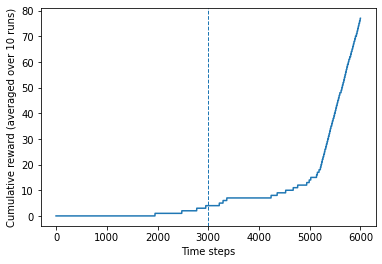

In [3]:
avg_cumulative_reward = run_q_learning(
    Environment(), NUM_RUNS, NUM_TIME_STEPS, NUM_TIME_STEPS_BEFORE_SECOND_WALL, EPS, LEARNING_RATE, GAMMA
)
plt.plot(np.arange(len(avg_cumulative_reward)), avg_cumulative_reward)
plt.axvline(x=NUM_TIME_STEPS_BEFORE_SECOND_WALL, linestyle="dashed", linewidth=1)
plt.xlabel("Time steps")
plt.ylabel(f"Cumulative reward (averaged over {NUM_RUNS} runs)")

In [4]:
avg_cumulative_reward = run_dyna_q(
    Environment(), NUM_RUNS, NUM_TIME_STEPS, NUM_TIME_STEPS_BEFORE_SECOND_WALL, EPS, LEARNING_RATE, GAMMA, N
)
plt.plot(np.arange(len(avg_cumulative_reward)), avg_cumulative_reward)
plt.axvline(x=NUM_TIME_STEPS_BEFORE_SECOND_WALL, linestyle="dashed", linewidth=1)
plt.xlabel("Time steps")
plt.ylabel(f"Cumulative reward (averaged over {NUM_RUNS} runs)")

In [ ]:
avg_cumulative_reward = run_dyna_q_plus(
    Environment(), NUM_RUNS, NUM_TIME_STEPS, NUM_TIME_STEPS_BEFORE_SECOND_WALL, EPS, LEARNING_RATE, GAMMA, N, KAPPA
)
plt.plot(np.arange(len(avg_cumulative_reward)), avg_cumulative_reward)
plt.axvline(x=NUM_TIME_STEPS_BEFORE_SECOND_WALL, linestyle="dashed", linewidth=1)
plt.xlabel("Time steps")
plt.ylabel(f"Cumulative reward (averaged over {NUM_RUNS} runs)")

In [ ]:
def run_dyna_q_plus_v2(env, num_runs, num_time_steps, num_time_steps_before_second_wall, eps, learning_rate, gamma, n, kappa):
    avg_cumulative_reward = np.zeros(num_time_steps)
    for _ in range(num_runs):
        cumulative_reward = np.zeros(num_time_steps)
        Q = np.zeros((env.grid_size[0], env.grid_size[1], len(env.available_actions)))
        model = {}
        for x in range(env.grid_size[0]):
            for y in range(env.grid_size[1]):
                for a in env.available_actions:
                    model[((x, y), a)] = (0, (x, y))
        steps_since_tried = np.zeros((env.grid_size[0], env.grid_size[1], len(env.available_actions)))
        state = env.start_state
        for t in range(num_time_steps):
            # Experience with the environment
            first_wall_active = True if t < num_time_steps_before_second_wall else False
            action = eps_greedy_action_selection(Q, state, eps)
            reward, new_state = env.take_action(state, action, first_wall_active)
            Q[state][action] += learning_rate * (reward + gamma * np.max(Q[new_state]) - Q[state][action])
            model[(state, action)] = (reward, new_state)
            steps_since_tried += 1
            steps_since_tried[state][action] = 0
            cumulative_reward = update_cumulative_reward(cumulative_reward, reward, t)
            state = new_state

            # Planning
            for _ in range(n):
                rand_state, rand_action = random.choice(list(model.keys()))
                reward, new_state = model[(rand_state, rand_action)]
                reward += kappa * np.sqrt(steps_since_tried[rand_state][rand_action])
                Q[rand_state][rand_action] += learning_rate * (reward + gamma * np.max(Q[new_state]) - Q[rand_state][rand_action])

        avg_cumulative_reward += cumulative_reward
    avg_cumulative_reward /= num_runs

    return avg_cumulative_reward